# Random Forest and Gradient Boosted Trees

In this lab assignment, you will implement a simplified version of Random Forest classifier and practice how to use and fine-tune Random Forest and Gradient Boosted Trees in scikit-learn. By comparing the model performance of various classifiers on a synthetic dataset, ranging from simple linear model to ensemble tree-based models (i.e. random forest and gradient boosted trees), we demonstrate the power of ensemble models in modeling complexity non-linear classification problems.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# make this notebook's output stable across runs
np.random.seed(0)

In [2]:
# helper functions used in this lab
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    """
    Plot the decision boundary of a learnt classifier
    """
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Implementation of Random Forest Classifier

<span style="color:orange">**Coding Part 1: Implement a simplified version of Random Forest.**</span> 

### Synthetic Moon dataset
In this lab, we will classify a moon shaped synthetic dataset with two features (_x1_ and _x2_) and two classes (0 or 1) with some added noise. 

In [3]:
# load the moon train and test data from CSV files
train = pd.read_csv("moon_train.csv")
test = pd.read_csv("moon_test.csv")

train_x = train.iloc[:,0:2]
train_y = train.iloc[:,2]

test_x = test.iloc[:,0:2]
test_y = test.iloc[:,2]

print("Number of train data: {}".format(len(train_y)))
print("Number of test data: {}".format(len(test_y)))

Number of train data: 3000
Number of test data: 1000


Text(0,0.5,'x2')

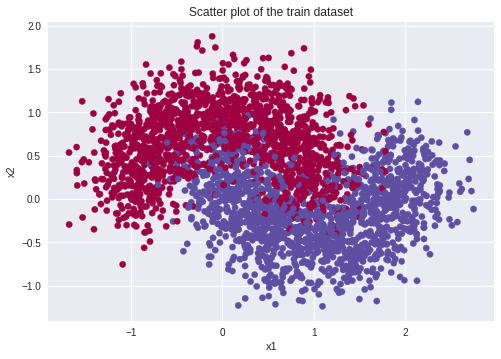

In [4]:
# plot the train dataset
plt.scatter(train_x.x1, train_x.x2, s=40, c=train_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the train dataset')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0,0.5,'x2')

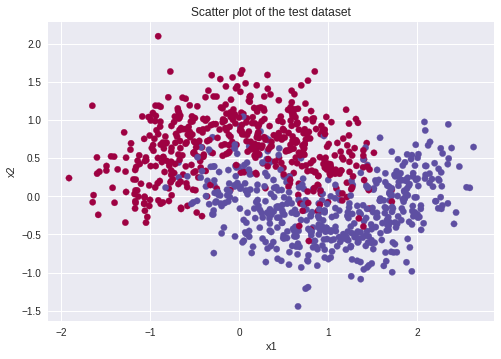

In [5]:
# plot the test dataset
plt.scatter(test_x.x1, test_x.x2, s=40, c=test_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the test dataset')
plt.xlabel('x1')
plt.ylabel('x2')

### Logistic Regression
First, we learn a linear regression classifier to separate the two classes in the moon dataset. Note that since logistic regression is a linear model, the decision boundary is a linear in the input space.

In [6]:
# Baseline 1: logistic regression classifier
parameters = {
    "penalty": ["l1", "l2"], 
    "C": [0.01, 0.1, 1]
}

lr_grid = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, cv=3)
lr_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(lr_grid.best_score_))
print("The best hyper parameter setting is {}".format(lr_grid.best_params_))

The best score is 0.846
The best hyper parameter setting is {'penalty': 'l1', 'C': 1}


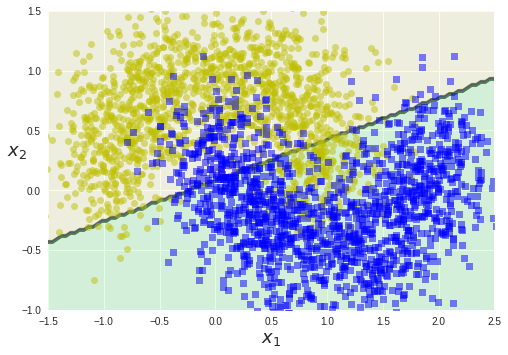

In [7]:
# plot the decision boundary
plot_decision_boundary(lr_grid, train_x.values, train_y.values)

In [8]:
# make prediction and evaluate the model performance on test data
test_z = lr_grid.predict(test_x)
test_z_prob = lr_grid.predict_proba(test_x)[:,1]

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model ROC AUC: {}".format(roc_auc_score(test_y, test_z_prob)))

model accuracy: 0.84
model ROC AUC: 0.9260359999999999


### Decision Tree Classifier
Then, we learn a decision tree classifier to separate the two classes in the moon dataset. Note that decision boundary is no longer linear.

In [9]:
# Baseline 2: Decision Tree classifier
parameters = {
    "max_depth": [2, 4], 
    "min_samples_split": [0.05, 0.1, 0.2]
}

dtc = DecisionTreeClassifier()
dtc_grid = GridSearchCV(dtc, parameters, cv=3)
dtc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(dtc_grid.best_score_))
print("The best hyper parameter setting is {}".format(dtc_grid.best_params_))

The best score is 0.8853333333333333
The best hyper parameter setting is {'max_depth': 2, 'min_samples_split': 0.05}


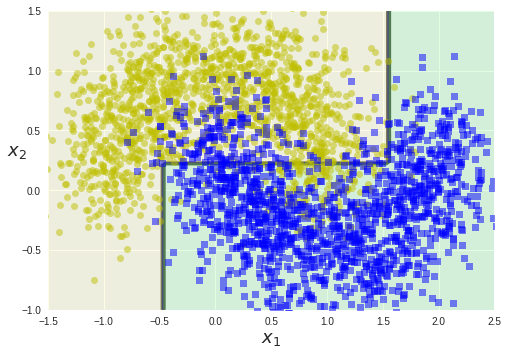

In [10]:
# plot the decision boundary
plot_decision_boundary(dtc_grid, train_x.values, train_y.values)

In [11]:
# make prediction and evaluate the model performance on test data
test_z = dtc_grid.predict(test_x)
test_z_prob = dtc_grid.predict_proba(test_x)[:,1]

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model ROC AUC: {}".format(roc_auc_score(test_y, test_z_prob)))

model accuracy: 0.892
model ROC AUC: 0.8990000000000001


### Implement a simplified version of Random Forest Classifier

In this exercise, you will implement the random forest classifier. 
- Use bootstrapping to generate different ensemble datasets, where you will train a separate classifier to each dataset.
- Apply grid search with cross-validation to learn and fine-tune each decision tree classifier.
- Implement two predict functions: one outputs the probabilities while the other outputs the predicted class.

In [12]:
class MyRandomForestClassifier:
    """
    Random Forest Classifier.
    """
    def __init__(self, n_estimators=100, models=None):
        self.n_estimators = n_estimators
        self.models = models

    def train(self, x, y):
        """
        TODO: Train random forest classifier using bootstrapping and decision tree as the base classifier
        """
        self.models = [None] * self.n_estimators
        for i in range(self.n_estimators):
            # boostrapping
            if i % 10 == 0:
                print("Bootstrapping for estimator {}.".format(i))
            x, y = resample(train_x.values, train_y, replace=True)

            # construct the logistic regression instance
            parameters = {
              "max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]
            }

            dtc_grid = GridSearchCV(DecisionTreeClassifier(), parameters, cv=3)
            dtc_grid.fit(x, y)

            self.models[i] = dtc_grid

    def predict_proba(self, x):
        """
        TODO: Make predictions (probabilities) with the trained random forest
        """
        if self.models == None:
            sys.exit("The model has not been trained yet. Please call train() first. Exiting...")

        predictions = pd.DataFrame(np.zeros((x.shape[0], self.n_estimators)))
        for i in range(self.n_estimators):
            predictions.iloc[:, i] = self.models[i].predict(x)

        return predictions.sum(axis=1) / self.n_estimators

    def predict(self, x):
        """
        TODO: Make predictions (the class/label) with the trained random forest
        """
        probabilities = self.predict_proba(x)
        prediction = pd.Series([1] * len(probabilities))
        prediction[probabilities < 0.5] = 0

        return prediction.values

### Train, predict and evaluate the random forest classifier

Even though this is a simplified version of random forest, we should see it outperforms the decision tree classifier above.

In [13]:
# Use the trained random forest model to make predictions on the test data and evaluate the model performance.

# train random forest classifier
mrfc = MyRandomForestClassifier(100)
mrfc.train(train_x, train_y)

# make predictions with the trained random forest
test_z = mrfc.predict(test_x)
test_z_prob = mrfc.predict_proba(test_x)

# evaluate the model performance
print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model ROC AUC: {}".format(roc_auc_score(test_y, test_z_prob)))

Bootstrapping for estimator 0.
Bootstrapping for estimator 10.
Bootstrapping for estimator 20.
Bootstrapping for estimator 30.
Bootstrapping for estimator 40.
Bootstrapping for estimator 50.
Bootstrapping for estimator 60.
Bootstrapping for estimator 70.
Bootstrapping for estimator 80.
Bootstrapping for estimator 90.
model accuracy: 0.892
model ROC AUC: 0.91693


---

## Random Forest

<span style="color:orange">**Coding Part 2: In this exercise, we will apply the Random Forest Classifier provided in scikit-learn to classify the synthetic moon data.**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default). Please refer to the [scikit-learn doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more details on how to use the API.

In [14]:
# TODO: fine-tune Random Forest classifier using grid search with cross-validation (GridSearchCV).
parameters = {
    "n_estimators": [200],
    "max_depth": [2, 4], 
    "min_samples_split": [0.05, 0.1, 0.2]
}

rfc_grid = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), parameters, cv=3)
rfc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(rfc_grid.best_score_))
print("The best hyper parameter setting is {}".format(rfc_grid.best_params_))

The best score is 0.8886666666666667
The best hyper parameter setting is {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 0.05}


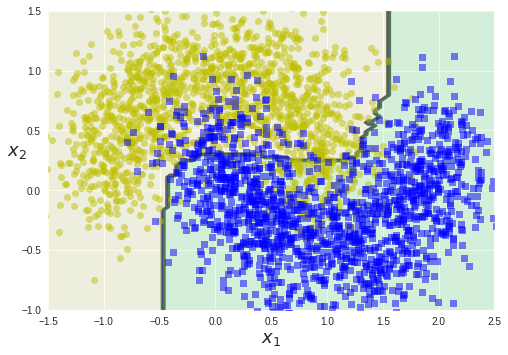

In [15]:
# plot the decision boundary
plot_decision_boundary(rfc_grid, train_x.values, train_y.values)

Notice that the decision boundary is no longer orthogonal to the x and y axises and is able to better separate the two classes in the moon dataset.

Now let's use the fine-tuned model to make predictions on the test dataset and evaluate it's performance in terms of accuracy and ROC AUC. It should outperform our simplified version of Random Forest as there are more optimizations being implemented in scikit-learn API.

In [16]:
# TODO: make prediction and evaluate the model performance on test data
test_z = rfc_grid.predict(test_x)
test_z_prob = rfc_grid.predict_proba(test_x)[:,1]

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model ROC AUC: {}".format(roc_auc_score(test_y, test_z_prob)))

model accuracy: 0.889
model ROC AUC: 0.954006


---

## Gradient Boosted Trees
<span style="color:orange">**Coding Part 3: In this exercise, we will apply the Gradient Boosted Tree classifier provided in scikit-learn to classify the synthetic moon dataset.**</span> 

Gradient Boosted Trees is a generalization of boosting to arbitrary differentiable loss functions, which can be used for both regression and classification problems. At a high level, gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. Gradient Boosted Trees, which is a special case of gradient boosting, uses regression trees as the base predictors and builds an additive model in a forward stage-wise fashion. In each stage, regression trees are fit on the negative gradient of the loss function used in a classification or a regression problem. Please refer to [Gradient Boosted Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) for more details on how to use the API.

Gradient boosting introduces a new hyperparameter *learning_rate*, which scales the contribution of each tree. If you set it to a low values, such as 0.1, you will need more trees in the ensemble to fit the training data, but the predictions will usually generalize better. This is a regularization technique called shrinkage. In the exercise below, please include *learning_rate* as a hyperparameter in the model fine-tuning.

In [17]:
# TODO: fine-tune Gradient Boosted Trees using grid search with cross-validation (GridSearchCV).
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1],
    "min_samples_split": [0.05, 0.1, 0.2],
    "max_depth":[2, 4],
    "n_estimators":[100]
}

gbc_grid = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)
gbc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(gbc_grid.best_score_))
print("The best hyper parameter setting is {}".format(gbc_grid.best_params_))

The best score is 0.9116666666666666
The best hyper parameter setting is {'min_samples_split': 0.1, 'n_estimators': 100, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.1}


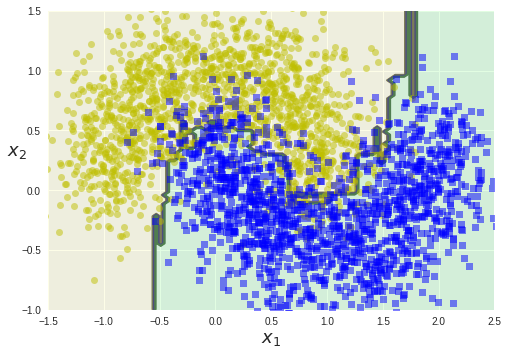

In [18]:
# plot the decision boundary for decision tree classifier
plot_decision_boundary(gbc_grid, train_x.values, train_y.values)

Now let's use the fine-tuned model to make predictions on the test dataset and evaluate its performance in terms of accuracy and ROC AUC.

In [19]:
# TODO: make prediction and evaluate the model performance on test data
test_z = gbc_grid.predict(test_x)
test_z_prob = gbc_grid.predict_proba(test_x)[:,1]

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model ROC AUC: {}".format(roc_auc_score(test_y, test_z_prob)))

model accuracy: 0.9
model ROC AUC: 0.96187


## Conclusion

By comparing the model performance as well as the decision boundaries learned from different classifiers on the same dataset, we clearly see Random Forest and Gradient Boosted Trees are capable of modeling more complex patterns in the data as compared to linear models and decision trees, leading to superior performance on the test dataset.

### End of ML 310 Lab Assignment 3
---
